In [ ]:
# written by evan groover, 2025

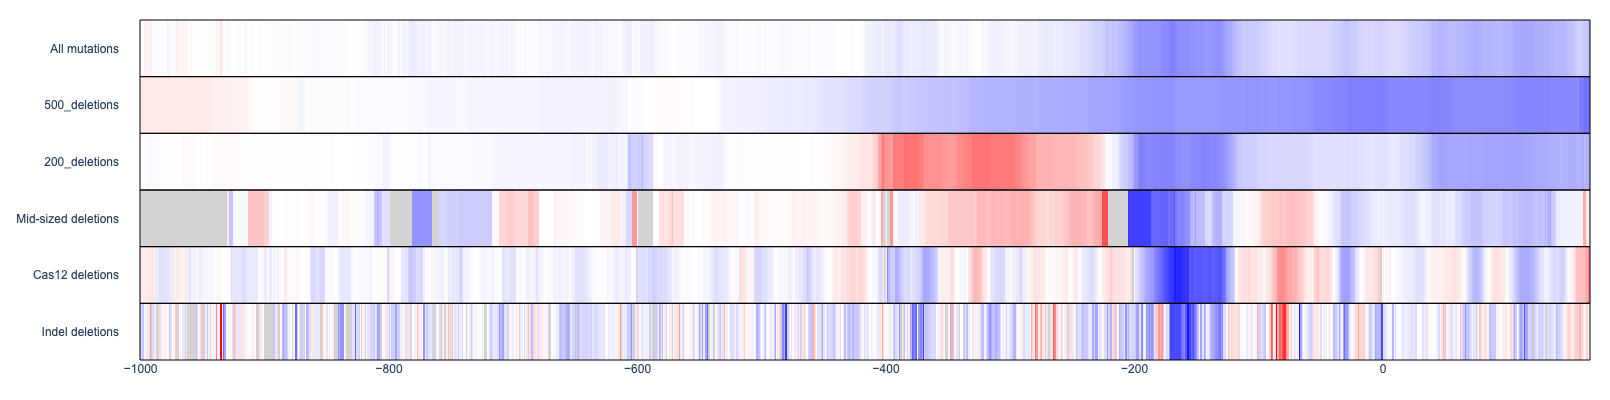

▶ Saved heatmap to 3C_log2_heatmap.pdf


<Figure size 640x480 with 0 Axes>

In [5]:
# FIGURE 3A: SbPsbS Heatmaps

import os
import re
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# LOAD DATA

file_path = '.../3C_log2.csv'
df = pd.read_csv(file_path)
df = df[df['mut_in_prom_utr'] == True]

# SET RANGE

positions = np.arange(-1000, 167)

cats = {
    c: {p: [] for p in positions}
    for c in [
        'all_mutations','500_deletions','200_deletions','mid_deletions',
        'cas12_deletions','indel_deletions','substitutions'
    ]
}
pattern_del = re.compile(r'([ACGT])(-?\d+)(_+)$')
pattern_sub = re.compile(r'([ACGT])(-?\d+)([ACGT])$')

# BIN DEL EFFECTS BY DELETION SIZE

for mut, beta in zip(df['mut'], df['beta']):
    m = pattern_del.match(mut)
    if m:
        _, spos, us = m.groups()
        start, length = int(spos), len(us)
        for p in range(start, start + length):
            if p in cats['all_mutations']:
                cats['all_mutations'][p].append(beta)
                if 0 <= length <= 11:   cats['indel_deletions'][p].append(beta)
                if 13 <= length <= 99 :cats['mid_deletions'][p].append(beta)
                if 100 <= length <= 250:cats['200_deletions'][p].append(beta)
                if 251 <= length <= 4000:cats['500_deletions'][p].append(beta)
                if length == 12:       cats['cas12_deletions'][p].append(beta)
    else:
        ms = pattern_sub.match(mut)
        if ms:
            pos = int(ms.group(2))
            if pos in cats['all_mutations']:
                cats['all_mutations'][pos].append(beta)
                cats['substitutions'][pos].append(beta)

# BUILD HEATMAP

heat_Z = {
    c: [[np.nan if not cats[c][p] else np.mean(cats[c][p]) for p in positions]]
    for c in cats
}

order = [
    ('all_mutations','All mutations'),
    ('500_deletions','500_deletions'),
    ('200_deletions','200_deletions'),
    ('mid_deletions','Mid-sized deletions'),
    ('cas12_deletions','Cas12 deletions'),
    ('indel_deletions','Indel deletions'),
]
N = len(order)

# MAKE FIGURE

heat_fig = make_subplots(rows=N, cols=1, shared_xaxes=True,
                         vertical_spacing=0, row_heights=[1/N]*N)
cscale = [[0,'blue'],[0.5,'white'],[1,'red']]
for i, (key, label) in enumerate(order, start=1):
    heat_fig.add_trace(go.Heatmap(
        z=heat_Z[key], x=positions, y=[label],
        colorscale=cscale, zmin=-1.5, zmax=1.5,
        showscale=False
    ), row=i, col=1)


shapes = []
for idx in range(1, N+1):
    y0, y1 = heat_fig.layout[f'yaxis{idx}'].domain
    shapes += [
        dict(type='rect', xref='paper', yref='paper',
             x0=0, x1=1, y0=0, y1=1,
             fillcolor='lightgray', line_width=0, layer='below'),
        dict(type='rect', xref='paper', yref='paper',
             x0=0, x1=1, y0=y0, y1=y1,
             line=dict(color='black', width=1),
             fillcolor='rgba(0,0,0,0)', layer='above')
    ]
heat_fig.update_layout(
    shapes=shapes,
    font=dict(family='Arial'),
    plot_bgcolor='white', paper_bgcolor='white',
    margin=dict(t=20,b=40,l=140,r=20),
    width=700, height=400
)

for idx in range(1, N+1):
    heat_fig.update_yaxes(
        row=idx, col=1, showgrid=False, showline=False,
        ticklabelposition='outside left', ticklabelstandoff=20,
        ticks='',
    )


heat_pdf = os.path.splitext(os.path.basename(file_path))[0] + '_heatmap.pdf'
heat_fig.write_image(os.path.join(os.path.dirname(file_path), heat_pdf))
heat_fig.show()

# SET HEATMAP RANGE AND PRINT

ticks = np.arange(-2.5, 2.51, 0.5)
print(f"▶ Saved heatmap to {heat_pdf}")
plt.tight_layout()
plt.show()



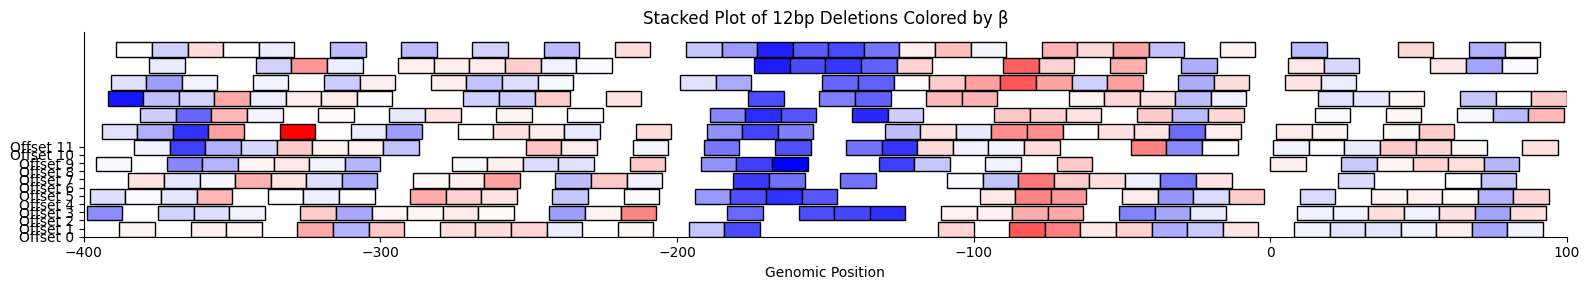

In [8]:
# FIGURE 3C: 12bp deletion plotter

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import re

# LOAD DATA
file_path = '.../3C_log2.csv' 
df = pd.read_csv(file_path)
df = df[df['mut_in_prom_utr'] == True]

# Extract 12bp deletions
pattern_del = re.compile(r'([ACGT])(-?\d+)(_+)$')
df_12 = []
for _, row in df.iterrows():
    m = pattern_del.match(row['mut'])
    if m:
        _, spos, us = m.groups()
        if len(us) == 12:
            df_12.append((int(spos), row['beta']))

df_12 = pd.DataFrame(df_12, columns=['start', 'beta'])

# SET RANGE
x_min = -400
x_max = 100

# MAKE PLOT
fig, ax = plt.subplots(figsize=(16, 3))
vmin, vmax = -1.5, 1.5
cmap = plt.get_cmap("bwr")
row_spacing = 2

for offset in range(12):  # 12 rows
    y = offset * row_spacing  # now rows are spaced out
    for x in range(x_min + offset, x_max - 11, 12):
        beta = df_12.loc[df_12['start'] == x, 'beta']
        if not beta.empty:
            norm = (beta.values[0] - vmin) / (vmax - vmin)
            color = cmap(norm)
            rect = patches.Rectangle((x, y), 12, row_spacing * 0.9, facecolor=color, edgecolor='black')
            ax.add_patch(rect)

ax.set_ylim(0, 12 * row_spacing)
ax.set_yticks([i * row_spacing for i in range(12)])
ax.set_yticklabels([f"Offset {i}" for i in range(12)])

ax.set_xlim(x_min, x_max)
ax.set_ylim(0, 25)
ax.set_xlabel('Genomic Position')
ax.set_title('Stacked Plot of 12bp Deletions Colored by β')
ax.set_yticks(range(12))
ax.set_yticklabels([f"Offset {i}" for i in range(12)])
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.savefig(".../cas12.pdf", bbox_inches='tight')


plt.show()


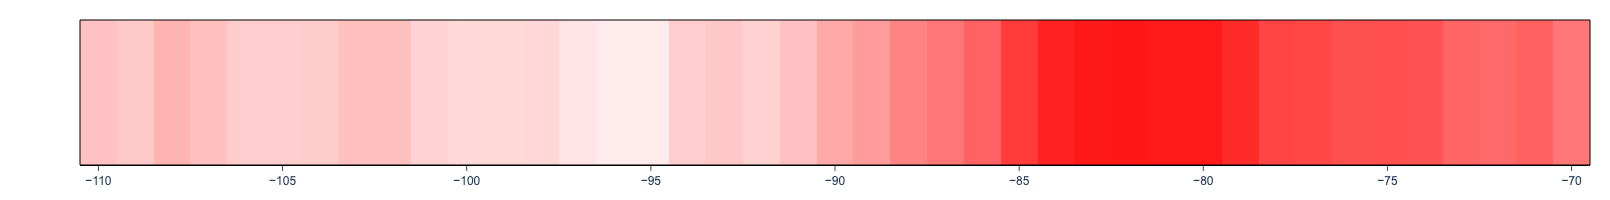

In [17]:
# FIGURE 3D-E: Individual Heatmaps


import os
import re
import numpy as np
import pandas as pd
import plotly.graph_objects as go

def plot_mutation_heatmap(
    csv_file: str,
    category: str,
    region: tuple,
    out_pdf: str = None
):
  
 
    df = pd.read_csv(csv_file)
    df = df[df['mut_in_prom_utr'] == True]

   
    full_positions = np.arange(-2000, 167)
    cats = {c: {p: [] for p in full_positions} for c in [
        'all_mutations','large_deletions','mid_deletions',
        'cas12_deletions','indel_deletions','substitutions'
    ]}

    pat_del = re.compile(r'([ACGT])(-?\d+)(_+)$')
    pat_sub = re.compile(r'([ACGT])(-?\d+)([ACGT])$')

    for _, row in df.iterrows():
        mut, beta = row['mut'], row['beta']
        m = pat_del.match(mut)
        if m:  
            _, spos, us = m.groups()
            start, length = int(spos), len(us)
            for p in range(start, start+length):
                if p in cats['all_mutations']:
                    cats['all_mutations'][p].append(beta)
                    if 1 <= length <= 2:
                        cats['indel_deletions'][p].append(beta)
                    if 10 <= length <= 100:
                        cats['mid_deletions'][p].append(beta)
                    if 100 <= length <= 500:
                        cats['large_deletions'][p].append(beta)
                    if length == 12:
                        cats['cas12_deletions'][p].append(beta)
        else:
            m2 = pat_sub.match(mut)
            if m2:
                pos = int(m2.group(2))
                if pos in cats['all_mutations']:
                    cats['all_mutations'][pos].append(beta)
                    cats['substitutions'][pos].append(beta)

    start, end = region
    positions = np.arange(start, end+1)
    z_row = [
        np.nan if not cats[category].get(p, []) else np.mean(cats[category][p])
        for p in positions
    ]

    fig = go.Figure()

    fig.add_trace(go.Heatmap(
        z=[z_row], x=positions, y=[category],
        colorscale=[[0, 'blue'], [0.5, 'white'], [1, 'red']],
        zmin=-.75, zmax=.75,
        showscale=False
    ))

    fig.update_layout(shapes=[dict(
        type='rect', xref='paper', yref='paper',
        x0=0, x1=1, y0=0, y1=1,
        line=dict(color='black', width=1),
        fillcolor='rgba(0,0,0,0)'
    )])

    fig.update_layout(
        width=800, height=200,
        font=dict(family='Arial'),
        plot_bgcolor='lightgrey', paper_bgcolor='white',
        margin=dict(t=20, b=20, l=80, r=20)
    )

    fig.update_yaxes(visible=False)
    fig.update_xaxes(
        showgrid=False, showline=True, linecolor='black',
        ticks='outside', ticklen=5, tickwidth=1
    )

    fig.show()

    if out_pdf:
        fig.write_image(out_pdf)

plot_mutation_heatmap(
    csv_file='.../3C_log2.csv',
    category='cas12_deletions',
    region=(-110, -70),
    out_pdf='heatmap_region.pdf'
)

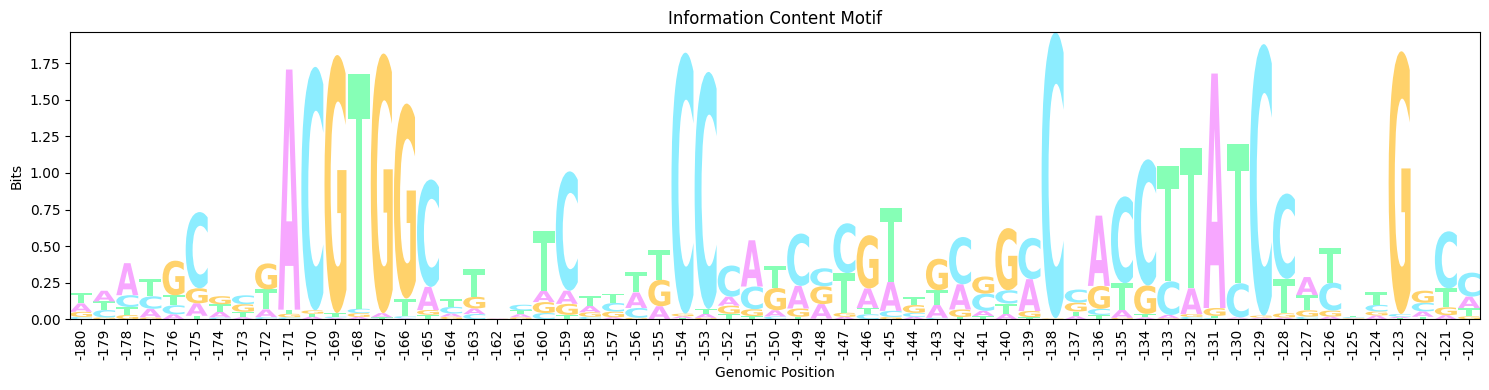

In [20]:
#FIGURE 3D: Logo Maker

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logomaker

# LOAD FILE AND DETERMINE SOFTMAX SENSITIVITY
csv_path = '.../3C_log2.csv'  
start_pos, end_pos = -180, -120        
output_pdf = 'motif_logo_wt.pdf'
beta_scale = 5  

df = pd.read_csv(csv_path)
mut_extracted = df['mut'].str.extract(r'^([ACGT])(-?\d+)([ACGT])$')
mut_extracted.columns = ['ref', 'pos', 'alt']
sub_df = df[mut_extracted.notnull().all(axis=1)].copy()
sub_df[['ref', 'pos', 'alt']] = mut_extracted
sub_df['pos'] = sub_df['pos'].astype(int)

sub_df = sub_df[(sub_df['pos'] >= start_pos) & (sub_df['pos'] <= end_pos)]

# REFERENCE SEQ

wt_seq = "AGCTGGAATGGGTACTCAACTGGACTACCTTTGTGACAGCAAGGGTGATATGCCATATCTTGATAACTTACAAGCTCATAGCTGATGCCCACAAATTTGGGAAGGGCATTGAGCTTCCGCTAGCTCTTCTTGGTATGGCAGGAATGAATCTGCTCAACATATTTCTAGGGCTTGATCTACTGAAAGCATTCACACGAGAAAGAAATCAGCAAAACCATCAGGACTGAATGCACCTTTCTTGACTGTGGTGTACTCTAAATTTTGAGAAGGCCGTAGTTCCGTTCCTGTAGGGATAGAGAGGTATGTTTAAAGTCTTAATTAGCAACTACACTAGAGGCTATTTATGTATGCATTCTTTATGTATACCAACACATGCTAATGCTAAGATCTCTACCAGAAAGGGTTGTTGCCAGCATGTGCATCCATGTAGATAACATTACTGTTCATTAGGAGAATGCAGGCGGGTACCTGGATGCAGGATTTTACATACATTCCTTCCCTTTGGTCCCAACTCGCAAACCTCATCTAAAGTAAACCCCGAAGCAACTTGTGGATTGGCCCTGTGAGGCTACAATGCTCTTATTTATTTAAATATTTGATTTGCAAAGCAAATATTGTGTGTGTGTGTGTGTGTGTGTGTTTTTTTTTGTTTATATGCATTGGCTCTACTGTATTACGGTTAGGGAAGGAAGAAGGTACTGCCCCATTTTCTTGCCTTAAACCTGGACTGATTCATTTTGACGTGTTCTGGGTCCACCCACAACGGAAAGCAAGCATTTGTATATGGATCTTATGCTTTTTTCATATTGACGTGTTTTGGGTCGGCCCACAACGGAAAACTTCAAAAAAAAAAAAAGGTCCCACCGTGATTCGAACCCAGGTCGCCAGATTCAAAGTCTGGAGTGCTAACCACTACACTATGGAACCATTTGTTGAGACTGATGTGCTGATGGTGATATTTATCTCTATCATGAACAACCAGCACATGGACCGTCCATTGGTCCGGAACCATTTGCTCTAAAGAACAGAATGGAACACCGGAATATCCAACGAATCCCTTGTAATTGTACCGCTATGAAATAGTAAATCCTCTTCTTCTTTTTTTTTGGCAAAGGGAATGAAAATAAATCTAACTTAGGCCTTGTTTAGTTGGCAAAAACTTTGGTTTCTGCCTACTGTAGCACTTTCGTTTTTATTTGACAAACATTGTCCAATCATGGAGTAACTAGGCTCAAAAGATTCATCTCACAAATTACAGTTAAACTGTGCAATTAGTTTTTATTTTTATCTATATTTAATGCTCCATGCATGCGATCAAAGATTTGATGTGACGGAGAATCTTGAAAATTTTTGCGAACTAAACAAGGCCTTACAGCAACATTGCCACAGCGGGTTTTTTACTTGGTGAAGAGTTTTCCTTCAAAATAGACCTTCAAGGTTCAGAACTTCAGATACAAAAATATACTTACTTTGCAGTGGAGGTTGAAATTTCTTAGCAAGATCCAATTCATCGACTTGAGAGAAACGAAAGAGCACGATGCTACGATCTGCTCCATACATGACAACCGTCACTAACAGACAGTAGAATGGACTCCTAGCAACTTCATTCACACATGCCTCAAGGCTGGAGGGGCAGAACAGAACACTTTTTGCTTGACGCGTGTATCTCACCGACCGACCAGCGCCATCAGTTTGTTGCAGCGCCTGACGCCCTCCCCCAATGCCTGCGTCTCCAGCCGTACGGAGGTCGCAGGACAGGAGCCGCACGCACGCTGGCTCCTGGGCTCCCTGGCCTCGGCGCGGCGCGGCCATAGATTGGATTCTCGGCGACGTGGCCTCCTGGCAACCCATCCCGCAACGGCGCACCCTATCCTCCGCCTCGCCGCTCGCCAGTCGCCAATCGACACCTCCAGTTGGCGCCACTCCAGCTTCACGCTGCCCGCGCCTGTGACCCCAATGCCCCCTTTCATAAGAACGGGACACGCGGCCTCGGAGCCAGTAGACACGGGAGCCCACGACCACGCAGCTCGCAGCCGCGCGCGCTCGCCTATACGACTACGAGTACACAGCTTCGATCCTCAGCGCGCGCGAGTACGTGGCTGCTGCGAATTCCTATCTTTCTCTGTGTTCGCGTGTTCGGTGTTCGTGAGTAGGCGCGGTCAGCACAT"
wt_map = {pos: base for pos, base in zip(range(-2000, -2000 + len(wt_seq)), wt_seq)}
bases = ['A', 'C', 'G', 'T']

for pos in range(start_pos, end_pos + 1):
    wt_base = wt_map.get(pos)
    if wt_base in bases:
        if not ((sub_df['pos'] == pos) & (sub_df['alt'] == wt_base)).any():
            sub_df = pd.concat([
                sub_df,
                pd.DataFrame([{'pos': pos, 'alt': wt_base, 'beta': 0.0}])
            ], ignore_index=True)

# BUILD PWM
pwm = pd.DataFrame(0.0, index=range(start_pos, end_pos + 1), columns=bases)
for pos in pwm.index:
    subset = sub_df[sub_df['pos'] == pos]
    beta_vals = {b: 0.0 for b in bases}
    for _, row in subset.iterrows():
        if row['alt'] in bases:
            beta_vals[row['alt']] = row['beta']
    scores = np.array([beta_scale * beta_vals[b] for b in bases])
    exp_scores = np.exp(scores - np.max(scores))
    probs = exp_scores / exp_scores.sum()
    pwm.loc[pos] = probs

def compute_ic(row):
    p = row.values
    with np.errstate(divide='ignore', invalid='ignore'):
        return 2 + np.sum(p * np.log2(p, where=(p > 0)))

ic_vector = pwm.apply(compute_ic, axis=1)
logo_matrix = pwm.mul(ic_vector, axis=0)

# SET COLORS
color_scheme = {
    'A': '#F7a7ff',  # blue
    'C': '#8cedff',  # green
    'G': '#ffd26b',  # orange
    'T': '#86ffb6' # red-orange
}

# PLOT

logo_df = logo_matrix.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 4))
logomaker.Logo(logo_df, ax=ax, color_scheme=color_scheme)

ax.set_xticks(range(len(pwm.index)))
ax.set_xticklabels(list(pwm.index), rotation=90)
ax.set_title("Information Content Motif")
ax.set_xlabel("Genomic Position")
ax.set_ylabel("Bits")
plt.tight_layout()
plt.savefig(output_pdf, dpi=300)
plt.show()


▶ Saved to substitution_heatmap.pdf


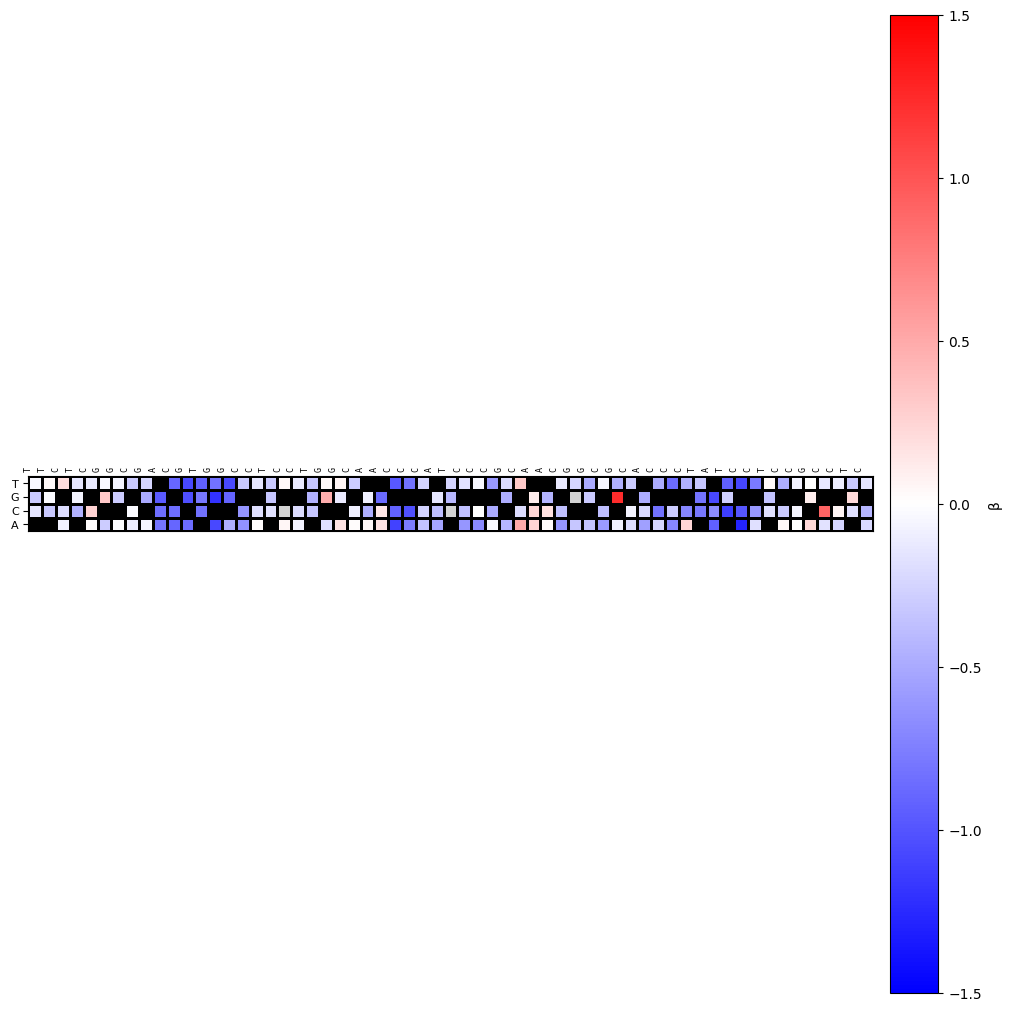

In [22]:
# FIGURE 3D-E: Substitution Heatmap

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

CSV_FILE     = '.../3C_log2.csv'

# PSBS SEQUENCE
FULL_REF_SEQ = (
    "AGCTGGAATGGGTACTCAACTGGACTACCTTTGTGACAGCAAGGGTGATATGCCATATCTTGATAACTTACAAGCTCATAGCTGATGCCCACAAATTTGGGAAGGGCATTGAGCTTCCGCTAGCTCTTCTTGGTATGGCAGGAATGAATCTGCTCAACATATTTCTAGGGCTTGATCTACTGAAAGCATTCACACGAGAAAGAAATCAGCAAAACCATCAGGACTGAATGCACCTTTCTTGACTGTGGTGTACTCTAAATTTTGAGAAGGCCGTAGTTCCGTTCCTGTAGGGATAGAGAGGTATGTTTAAAGTCTTAATTAGCAACTACACTAGAGGCTATTTATGTATGCATTCTTTATGTATACCAACACATGCTAATGCTAAGATCTCTACCAGAAAGGGTTGTTGCCAGCATGTGCATCCATGTAGATAACATTACTGTTCATTAGGAGAATGCAGGCGGGTACCTGGATGCAGGATTTTACATACATTCCTTCCCTTTGGTCCCAACTCGCAAACCTCATCTAAAGTAAACCCCGAAGCAACTTGTGGATTGGCCCTGTGAGGCTACAATGCTCTTATTTATTTAAATATTTGATTTGCAAAGCAAATATTGTGTGTGTGTGTGTGTGTGTGTGTTTTTTTTTGTTTATATGCATTGGCTCTACTGTATTACGGTTAGGGAAGGAAGAAGGTACTGCCCCATTTTCTTGCCTTAAACCTGGACTGATTCATTTTGACGTGTTCTGGGTCCACCCACAACGGAAAGCAAGCATTTGTATATGGATCTTATGCTTTTTTCATATTGACGTGTTTTGGGTCGGCCCACAACGGAAAACTTCAAAAAAAAAAAAAGGTCCCACCGTGATTCGAACCCAGGTCGCCAGATTCAAAGTCTGGAGTGCTAACCACTACACTATGGAACCATTTGTTGAGACTGATGTGCTGATGGTGATATTTATCTCTATCATGAACAACCAGCACATGGACCGTCCATTGGTCCGGAACCATTTGCTCTAAAGAACAGAATGGAACACCGGAATATCCAACGAATCCCTTGTAATTGTACCGCTATGAAATAGTAAATCCTCTTCTTCTTTTTTTTTGGCAAAGGGAATGAAAATAAATCTAACTTAGGCCTTGTTTAGTTGGCAAAAACTTTGGTTTCTGCCTACTGTAGCACTTTCGTTTTTATTTGACAAACATTGTCCAATCATGGAGTAACTAGGCTCAAAAGATTCATCTCACAAATTACAGTTAAACTGTGCAATTAGTTTTTATTTTTATCTATATTTAATGCTCCATGCATGCGATCAAAGATTTGATGTGACGGAGAATCTTGAAAATTTTTGCGAACTAAACAAGGCCTTACAGCAACATTGCCACAGCGGGTTTTTTACTTGGTGAAGAGTTTTCCTTCAAAATAGACCTTCAAGGTTCAGAACTTCAGATACAAAAATATACTTACTTTGCAGTGGAGGTTGAAATTTCTTAGCAAGATCCAATTCATCGACTTGAGAGAAACGAAAGAGCACGATGCTACGATCTGCTCCATACATGACAACCGTCACTAACAGACAGTAGAATGGACTCCTAGCAACTTCATTCACACATGCCTCAAGGCTGGAGGGGCAGAACAGAACACTTTTTGCTTGACGCGTGTATCTCACCGACCGACCAGCGCCATCAGTTTGTTGCAGCGCCTGACGCCCTCCCCCAATGCCTGCGTCTCCAGCCGTACGGAGGTCGCAGGACAGGAGCCGCACGCACGCTGGCTCCTGGGCTCCCTGGCCTCGGCGCGGCGCGGCCATAGATTGGATTCTCGGCGACGTGGCCTCCTGGCAACCCATCCCGCAACGGCGCACCCTATCCTCCGCCTCGCCGCTCGCCAGTCGCCAATCGACACCTCCAGTTGGCGCCACTCCAGCTTCACGCTGCCCGCGCCTGTGACCCCAATGCCCCCTTTCATAAGAACGGGACACGCGGCCTCGGAGCCAGTAGACACGGGAGCCCACGACCACGCAGCTCGCAGCCGCGCGCGCTCGCCTATACGACTACGAGTACACAGCTTCGATCCTCAGCGCGCGCGAGTACGTGGCTGCTGCGAATTCCTATCTTTCTCTGTGTTCGCGTGTTCGGTGTTCGTGAGTAGGCGCGGTCAGCACAT"
)
FULL_START   = -2000  # DO NOT CHANGE     
REGION_START =  -180
REGION_END   =  -120
OUT_PDF      = 'substitution_heatmap.pdf'

# HEATMAP RANGE + SETUP
BETA_MIN, BETA_MAX = -1.5, 1.5
BORDER_WIDTH = 1.0
WT_COLOR = 'black'



if REGION_START < FULL_START or REGION_END >= FULL_START + len(FULL_REF_SEQ):
    raise ValueError("Region outside full reference bounds")
start_ix = REGION_START - FULL_START
end_ix   = REGION_END   - FULL_START + 1
REF_SEQ = FULL_REF_SEQ[start_ix:end_ix]


n_pos = REGION_END - REGION_START + 1
if len(REF_SEQ) != n_pos:
    raise RuntimeError("Extracted region length mismatch")

df = pd.read_csv(CSV_FILE)
df = df[df['mut_in_prom_utr'] == True]

bases = ['A','C','G','T']
n = n_pos
heat = np.full((4, n), np.nan)
groups = {(i,b): [] for i in range(n) for b in bases}
subs = re.compile(r'^([ACGT])(-?\d+)([ACGT])$')

for _, row in df.iterrows():
    m = subs.match(row['mut'])
    if not m:
        continue
    orig, spos, new = m.groups()
    spos = int(spos)
    if new == orig:
        continue
    idx = spos - REGION_START
    if 0 <= idx < n:
        groups[(idx, new)].append(row['beta'])

wt_mask = np.zeros((4, n), dtype=bool)
for bi, base in enumerate(bases):
    for pos in range(n):
        # WT positions
        if REF_SEQ[pos] == base:
            heat[3-bi, pos] = 0.0
            wt_mask[3-bi, pos] = True
        # substitutions
        vals = groups[(pos, base)]
        if vals:
            heat[3-bi, pos] = np.mean(vals)

mask = np.isnan(heat)
heat_ma = np.ma.masked_where(mask, heat)

fig, ax = plt.subplots(
    figsize=(10, 10),
    constrained_layout=True
)

x_edges = np.arange(REGION_START, REGION_END + 2)
y_edges = np.arange(0, 5)

cmap = plt.cm.bwr
cmap.set_bad('lightgray')
norm = colors.Normalize(vmin=BETA_MIN, vmax=BETA_MAX)

pcm = ax.pcolormesh(
    x_edges, y_edges, heat_ma,
    cmap=cmap, norm=norm,
    edgecolors='black', linewidth=BORDER_WIDTH
)

for bi in range(4):
    for pos in range(n):
        if wt_mask[bi, pos]:
            x0 = REGION_START + pos
            y0 = bi
            rect = Rectangle(
                (x0, y0), 1, 1,
                facecolor=WT_COLOR,
                edgecolor='black',
                linewidth=BORDER_WIDTH,
                zorder=2
            )
            ax.add_patch(rect)

ax.set_aspect('equal')
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticklabels(['A','C','G','T'], fontsize=8)
ax.yaxis.tick_left()

ax.set_xticks(np.arange(REGION_START, REGION_END + 1))
ax.set_xticklabels(list(REF_SEQ), fontfamily='monospace', fontsize=6, rotation=90)
ax.xaxis.tick_top()
ax.tick_params(axis='x', length=0)

cbar = fig.colorbar(pcm, ax=ax, pad=0.02)
cbar.set_label('β')

plt.savefig(OUT_PDF, dpi=300)
print(f"▶ Saved to {OUT_PDF}")
plt.show()
